In [1]:
import os
os.chdir('/home/jpmarceaux/Simulations/KalmanFiltering_Sandia2021')
from kalman_gst import *
os.chdir('/home/jpmarceaux/Simulations/KalmanFiltering_Sandia2021/UnscentedFiltering')
from pygsti.modelpacks import smq1Q_XYI as std

In [2]:
def dirichlet_covar(count_vec):
    total_counts = sum(count_vec)
    hdims = len(count_vec)
    mean_frequency = ( count_vec + np.ones(hdims) )/( total_counts + hdims )
    return 1/(total_counts + hdims + 1) * categorical_covar(mean_frequency)


def null_chi2_test(model, dataset, circ_list):
    chi2_stat = 1
    for idx, circ in enumerate(circ_list):
        cvec = vector_from_outcomes(dataset[circ].counts())
        rmat = dirichlet_covar(cvec)
        
        
def observation_chi2_test(model, model_covar, circ, count_vec):
    total_counts = sum(count_vec)
    hdims = len(count_vec)
    mean_frequency = ( count_vec + np.ones(hdims) )/( total_counts + hdims )
    rmat = categorical_covar(mean_frequency) # estimate of sampling covar
    observation = count_vec/total_counts
    prediction = vector_from_outcomes(model.probabilities(circ), hdims)
    innov = observation - prediction 
    jac = matrix_from_jacob(model.sim.dprobs(circ), hdims)
    smat = rmat + jac@model_covar@jac.T
    return innov.T@np.linalg.pinv(smat)@innov

In [3]:
SEED = 2021
SAMPLES = 256
np.random.seed(SEED)

# Example 1

Fixed FOGI model with different start points

In [4]:
# setup the datagen model
max_fogi_error_rate = 0.15
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
target_model = mdl_datagen.copy()
np.random.seed(SEED)
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [5]:
# check that the datagen model is CPTP and print metrics w.r.t. the target model
print('Model is CPTP... ', model_is_cptp(mdl_datagen))
print('avg. gate-set infidelity: ', avg_gs_infidelity(mdl_datagen, target_model))
print('mean square error: ', mserror(mdl_datagen, target_model))

Model is CPTP...  True
avg. gate-set infidelity:  0.14613773365572733
mean square error:  0.14931811645287552


In [6]:
# make an edesign and simulate the data
maxLengths = [1,2,4, 8, 16, 32]
maxlength_edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, maxlength_edesign, SAMPLES, seed=SEED) #, sample_error='none')

In [7]:
mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.7s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.4s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.8s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---



KeyboardInterrupt



In [ ]:
%matplotlib qt5

In [ ]:
# run three FOGI Kalman Filters

x0_zero = np.zeros(len(target_model.to_vector()))
x0_mle = mle_estimates[0].to_vector()
x0_bad = abs(np.random.multivariate_normal(np.zeros(target_model.num_params), 0.9*np.eye(target_model.num_params)))

covar_strength = 0.1

zero_ekf = setup_extended(target_model, x0_zero, covar_strength*np.eye(len(x0_zero)))
mle1_ekf = setup_extended(target_model, x0_mle, covar_strength*np.eye(len(x0_zero)))
gaussian_ekf = setup_extended(target_model, x0_bad, covar_strength*np.eye(len(x0_zero)))

max_itr = 1
max_itr_epsilon = 1e-4

Q_add = 0*np.eye(len(target_model.to_vector()))
R_add = 0*np.eye(2)

# run zero filter and make data
zero_model_vectors = dict()
zero_covars = dict()
mle1_model_vectors = dict()
mle1_covars = dict()
gaussian_model_vectors = dict()
gaussian_covars = dict()

idx = 0
zero_model_vectors[idx] = zero_ekf.model.to_vector()
zero_covars[idx] = zero_ekf.P
mle1_model_vectors[idx] = mle1_ekf.model.to_vector()
mle1_covars[idx] = zero_ekf.P
gaussian_model_vectors[idx] = gaussian_ekf.model.to_vector()
gaussian_covars[idx] = zero_ekf.P
idx += 1

# run over the largest set of GST circuits
for circ in tqdm(maxlength_edesign.circuit_lists[-1]):
    counts = dataset[circ].counts
    cvec = vector_from_outcomes(counts, 2**circ.width)
    #req = cvec/sum(cvec)

    #_filter_prior = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
    #ata_prior_innnovs[idx] = freq - p_filter_prior

    zero_prior_innov, _ = zero_ekf.update(circ, cvec, [-1, 1], Q_add, R_add, max_itr, max_itr_epsilon)
    mle1_prior_innov, _ = mle1_ekf.update(circ, cvec, [-1, 1], Q_add, R_add, max_itr, max_itr_epsilon)
    gaus_prior_innov, _ = gaussian_ekf.update(circ, cvec, [-1, 1], Q_add, R_add, max_itr, max_itr_epsilon)
    #kgain = ekf.update_approx(circ, cvec, jdict[circ], hdict[circ], max_itr, max_itr_epsilon, Q_add, R_add)
    
    
    zero_model_vectors[idx] = zero_ekf.model.to_vector()
    zero_covars[idx] = zero_ekf.P
    mle1_model_vectors[idx] = mle1_ekf.model.to_vector()
    mle1_covars[idx] = mle1_ekf.P
    gaussian_model_vectors[idx] = gaussian_ekf.model.to_vector()
    gaussian_covars[idx] = gaussian_ekf.P

    #p_filter_post = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
    #data_post_innovs[idx] = freq - p_filter_post 
    idx += 1
num_circs = idx

In [14]:
plt_spacing = 20
%matplotlib inline
yrange = [-4.5, 0]

germ_length_ranges = {
    0: [0, 92], 
    1: [92, 168], 
    2: [168, 285], 
    3: [285, 448],
    4: [448, 616], 
    5: [616, 784], 
    6: [794, 952], 
    7: [952, 1120], 
    8: [1120, 1288], 
}

In [26]:
make_error_plot('Target Seed EKF', zero_model_vectors, mdl_datagen.to_vector(), zero_covars, yrange, mle_estimates, germ_length_ranges, plt_spacing)

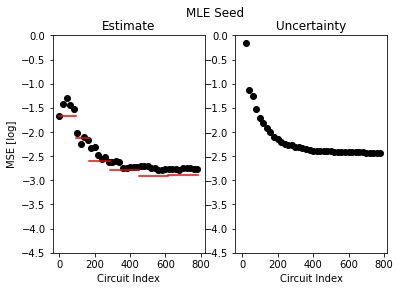

In [17]:
make_error_plot('MLE Seed', mle1_model_vectors, mdl_datagen.to_vector(), mle1_covars, yrange, mle_estimates, germ_length_ranges, plt_spacing)

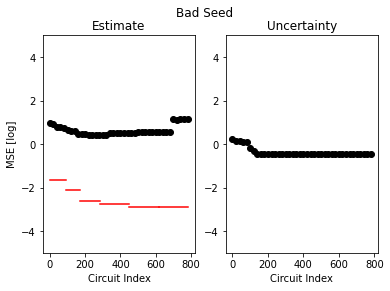

In [18]:
make_error_plot('Bad Seed', gaussian_model_vectors, mdl_datagen.to_vector(), gaussian_covars, [-5, 5], mle_estimates, germ_length_ranges, plt_spacing)

# Unscented Filtering

In [8]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise

In [9]:
def fx(x, dt):
    return x

def model_wrapper(x_state, circ, model):
    model.from_vector(x_state)
    return vector_from_outcomes(model.probabilities(circ), 2**circ.width)

# run three FOGI Kalman Filters

x0_zero = np.zeros(len(target_model.to_vector()))

covar_strength = 0.01

dt = 1
points = MerweScaledSigmaPoints(target_model.num_params, alpha=.1, beta=2., kappa=-1)
ukf = UnscentedKalmanFilter(target_model.num_params, 2, dt=0, hx=model_wrapper, fx=fx, points=points)
ukf.Q = 1e-9*np.eye(target_model.num_params)
R_add = 1e-9*np.eye(2)
ukf_filter_model = target_model.copy()

ukf.x = x0_zero
ukf.P *= covar_strength

max_itr = 1
max_itr_epsilon = 1e-4


# run zero filter and make data
ukf_model_vectors = dict()
ukf_covars = dict()

idx = 0
ukf_model_vectors[idx] = ukf.x
ukf_covars[idx] = ukf.P
idx += 1

# run over the largest set of GST circuits
for circ in tqdm(maxlength_edesign.circuit_lists[-1]):
    counts = dataset[circ].counts
    cvec = vector_from_outcomes(counts, 2**circ.width)
    freq = cvec/sum(cvec)
    #req = cvec/sum(cvec)

    #_filter_prior = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
    #ata_prior_innnovs[idx] = freq - p_filter_prior
    
    R_obs = categorical_covar(freq)/sum(cvec)
    ukf.predict()
    ukf.update(freq, R=R_obs+R_add, circ=circ, model=ukf_filter_model)
    
    #kgain = ekf.update_approx(circ, cvec, jdict[circ], hdict[circ], max_itr, max_itr_epsilon, Q_add, R_add)
    
    
    ukf_model_vectors[idx] = ukf.x
    ukf_covars[idx] = ukf.P

    idx += 1
num_circs = idx

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 784/784 [03:37<00:00,  3.60it/s]


In [10]:
%matplotlib qt5
yrange = [-3.5, 0]

In [11]:
experimental_loglikelihood?

Signature: experimental_loglikelihood(circuit_list, dataset, model)
Docstring:
multinomial likelihood of observations under the given model 

assumes all the circuits have the same number of qubits
File:      ~/Simulations/KalmanFiltering_Sandia2021/kalman_gst.py
Type:      function


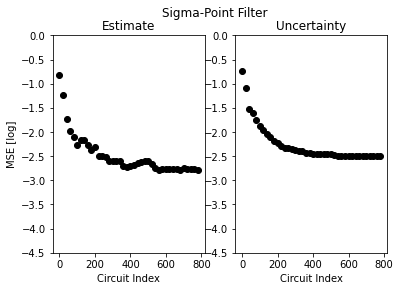

In [15]:
make_error_plot('Sigma-Point Filter', ukf_model_vectors, mdl_datagen.to_vector(), ukf_covars, yrange, None, germ_length_ranges, plt_spacing)

In [ ]:
# try filtering with gauge dof
target_model = std.target_model('H+S')
x0_zero = np.zeros(len(target_model.to_vector()))

covar_strength = 0.01

dt = 1
points = MerweScaledSigmaPoints(target_model.num_params, alpha=.1, beta=2., kappa=-1)
ukf = UnscentedKalmanFilter(target_model.num_params, 2, dt=0, hx=model_wrapper, fx=fx, points=points)
ukf.Q = 1e-9*np.eye(target_model.num_params)
R_add = 1e-9*np.eye(2)
ukf_filter_model = target_model.copy()

ukf.x = x0_zero
ukf.P *= covar_strength

max_itr = 1
max_itr_epsilon = 1e-4


# run zero filter and make data
ukf_model_vectors = dict()
ukf_covars = dict()

idx = 0
ukf_model_vectors[idx] = ukf.x
ukf_covars[idx] = ukf.P
idx += 1

# run over the largest set of GST circuits
for circ in tqdm(maxlength_edesign.circuit_lists[-3]):
    counts = dataset[circ].counts
    cvec = vector_from_outcomes(counts, 2**circ.width)
    freq = cvec/sum(cvec)
    #req = cvec/sum(cvec)

    #_filter_prior = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
    #ata_prior_innnovs[idx] = freq - p_filter_prior
    
    R_obs = categorical_covar(freq)/sum(cvec)
    ukf.predict()
    ukf.update(freq, R=R_obs+R_add, circ=circ, model=ukf_filter_model)
    
    #kgain = ekf.update_approx(circ, cvec, jdict[circ], hdict[circ], max_itr, max_itr_epsilon, Q_add, R_add)
    
    
    ukf_model_vectors[idx] = ukf.x
    ukf_covars[idx] = ukf.P

    idx += 1
num_circs = idx

In [ ]:
ukf_filter_model.from_vector(ukf.x)

In [ ]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, ukf_filter_model)

In [147]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, ukf_filter_model)

-4511.35005401106

In [142]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, mle_estimates[-1])

-4509.238202258466

In [149]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, zero_ekf.model)

-4509.754598082219

In [141]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, mdl_datagen)

-4517.752664028252

In [150]:
mserror(zero_ekf.model, mle_estimates[-1])

0.00028562257365945324

In [151]:
mserror(zero_ekf.model, mdl_datagen)

0.0017239843878938401

In [152]:
mserror(mle_estimates[-1], mdl_datagen)

0.0013312697673827593

# Covar Analysis

In [86]:
def plot_covar_evals(covar_dict):
    evals = []
    for c in range(num_circs):
        circ_eval, _ = np.linalg.eig(covar_dict[c])
        evals.append(circ_eval)
    plt.matshow(abs(np.array(evals).T))
    
def plot_covar_svals(covar_dict):
    svals = []
    for c in range(num_circs):
        _, circ_sval, _ = np.linalg.svd(covar_dict[c])
        svals.append(circ_sval)
    plt.matshow(abs(np.array(svals).T))

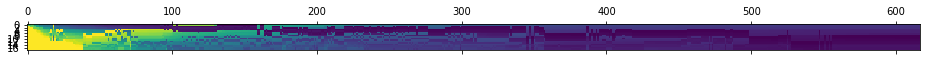

In [87]:
plot_covar_evals(mle1_covars)

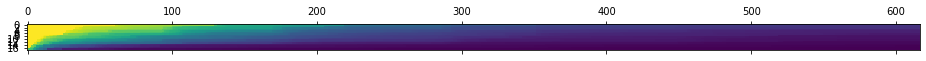

In [88]:
plot_covar_svals(mle1_covars)

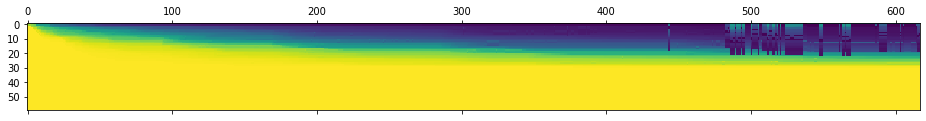

In [91]:
plot_covar_evals(cptp_mle1_covars)

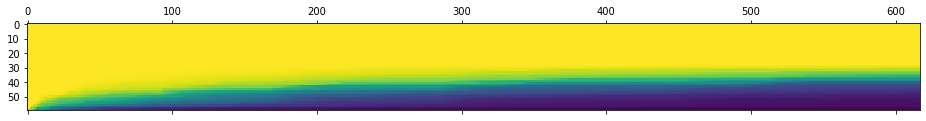

In [92]:
plot_covar_svals(cptp_mle1_covars)

In [ ]:
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
datagen_models = []
estimates = []
data_sets = []
edesign_sets = []
for e in error_strengths:
    ar = e * np.random.rand(len(ar))
    mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)
    datagen_models.append(mdl_datagen.copy())
    est, ds, edesigns = make_mle_estimates(mdl_datagen, target_model, [1, 2, 4, 8, 16], samples)
    estimates.append(est)
    data_sets.append(ds)
    edesign_sets.append(edesigns)